# DM PPC
## Clément VIGAND - Marie PONTALIER

In [1]:
from config import setup
setup()

In [2]:
## install docplex first with $pip install docplex
from docplex.cp.model import *
from docplex.cp.config import get_default

# Première Partie

On utilise tout au long de ce sujet deux ensembles d’agents H = {h1, . . . hn} et F = {f1, . . . fn}.

Chaque agent hi ∈ H exprime ses préférences de couplage avec un agent de F à travers une liste L(hi) contenant les éléments de F sans duplication. 
Pour tout k ∈ [1, n − 1], hi préfère être couplé avec le kème agent dans L(hi) que le k + 1ème agent.
De la même façon, chaque agent fj ∈ F exprime ses préférences de couplage avec un agent de H à travers une liste
L(fj ).

Un tuple (h, f ) est appelé un couple si h ∈ H et f ∈ F . 

Soit M un ensemble de couples. 
Un agent a préfère un agent b à sa situation dans M si a n’appartient à aucun couple dans M ou si a préfère b à son partenaire dans M . 
Un couple (h, f ) ∈ M bloque M si h préfère f à sa situation dans M et f préfère h à sa situation dans M.
Un mariage stable est un ensemble de couples M tel que chaque agent est couplé avec un seul agent et M n’admet
aucun couple bloquant.
On note qu’une instance de ce problème peut admettre plusieurs solutions.

La table 1 présente une instance avec n = 4. 
La séquence L[hi] est la liste d’agents dans F ordonnée selon les préférences de hi. 
Dans cet exemple, h3 préfère f2 à f4, et f4 à f1, etc.
M1 = {(h1, f2), (h2, f1), (h3, f3), (h4, f4)} n’est pas stable car h3 préfère f2 à son partenaire et f2 préfère h3 à son partenaire. Dans ce cas (h3, f2) bloque M1.
M2 = {(h1, f3), (h2, f4), (h3, f2), (h4, f1)} est un mariage stable car il n’existe aucun couple bloquant.


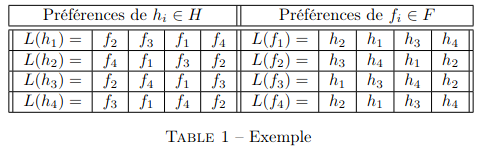


### Question 1

Proposez un modèle de programmation par contrainte pour trouver un mariage stable. Le modèle peut inclure
des contraintes logiques (par exemple if_then). L’utilisation de ce genre de contraintes est accessible dans
la documentation du solveur. Utilisez la recherche en profondeur par défaut sans préciser des heuristiques de
branchements. N’affichez pas les traces d’exécutions internes du solveur.

In [3]:
def couple_model(Lh, Lf, n):
    mdl = CpoModel(name='couples model')
    
    # variables représentant à qui sont liés les h et les f
    h = mdl.integer_var_list(n, 0, n-1, 'h')
    f = mdl.integer_var_list(n, 0, n-1, 'f')
    
    # On parcourt tous les hommes
    for i in range(n):
        # garantit les couples dans les 2 sens
        mdl.add(mdl.element(f, h[i]) == i)
        for j in range(n):
            # garantit l'unicité des conjoints
            if j != i:
                mdl.add(h[i] != h[j])
                mdl.add(f[i] != f[j])
        
        # On parcourt toutes les femmes possibles qui ne sont pas la préférée absolue
        for k in range(1, n):
            currentFemme = Lh[i][k]
            # On parcourt toutes les femmes préférées par rapport à currentFemme
            for fPrefIndex in range(k):
                fPref = Lh[i][fPrefIndex]
                # Index de l'homme i dans les préférences de la femme fPref
                indexHomme = Lf[fPref].index(i)
                if indexHomme < n:
                    # Parcours tous les hommes moins bien que i pour fPref
                    for hNotPrefIndex in range(indexHomme+1, n):
                        hNotPref = Lf[fPref][hNotPrefIndex]
                        # Contrainte empêchant les couples bloquants
                        mdl.add(if_then(h[i] == currentFemme, f[fPref] != hNotPref))
    return h, f, mdl
            

### Question 2

Testez le modèle avec l’exemple ci-dessus (ou un autre exemple) en affichant toutes les solutions. Affichez chaque
solution avec un format que vous jugez compréhensible.

In [4]:
n = 4
Lh = [[1, 2, 0, 3],
      [3, 0, 2, 1],
      [1, 3, 0, 2],
      [2, 0, 3, 2]]
Lf = [[1, 0, 2, 3],
      [2, 3, 0, 1],
      [0, 2, 3, 1],
      [1, 0, 2, 3]]

h, f, mdl = couple_model(Lh, Lf, n)
lsols = mdl.start_search(trace_log = False, SearchType="DepthFirst")

# Affichage des solutions
for sol in lsols:
    for i in range(n):
        print("(h_{0}, {1})".format(i, f[sol[h[i]]].name))
    print()

(h_0, f_2)
(h_1, f_3)
(h_2, f_1)
(h_3, f_0)



### Question 3

Proposez deux stratégies de recherches différentes qui vous semblent très différentes (i.e., deux combinaisons
de type <heuristique de choix de variables + heuristique de choix de valeurs>). On note ces deux stratégies
par S1 et S2

### Question 4

On veut tester S1 et S2 avec une recherche en profondeur sans et avec randomisation. Voici le protocole de
l’étude expérimentale :

— Générez différentes instances randomisées du problème avec différentes tailles (à partir de n = 5). Pour
chaque taille, générez 5 instances.



In [6]:
import random

def random_instances(tailles):

    Liste_modeles = []

    for i in tailles :
        n = i
        #valeurs possibles pour les préférences
        liste_numeros = [j for j in range(i)]
    
        #5 instances par taille
        for k in range(5):
        
            Lh = []
            Lf = []
        
            # génération des préférences de manière aléatoire
            for j in range(i) :
                random.shuffle(liste_numeros)
                Lh.append(liste_numeros[:])
                random.shuffle(liste_numeros)
                Lf.append(liste_numeros[:])
                
            #on ajoute l'instance créée à la liste des instances        
            Liste_modeles.append([Lh, Lf, n])

    return Liste_modeles
    

liste_n = [5, 8, 10, 12, 15]    
instances = random_instances(liste_n)


#print(X)
# Format : [ [ [[preference H1],[preference H2]], [[preference F1],[preference F2]], n ] , idem ]

— Lancez les 4 expérimentations (S1 et S2 avec une recherche en profondeur sans et avec restart) avec
vos jeux de données. Fixez le temps limite à 200s pour chaque exécution 1.

— Reportez le temps d’exécution et le nombre de nœuds dans des figures en fonction de la taille.

— Quelles sont vos conclusions ?

In [7]:
# Temps de recherche et nombre de noeuds pour chaque heuristique
meanTime = [[0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]]
nbNodes = [[0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]]

#On récupère les différentes instances
for i in range(len(instances)) :
    
    Lh = instances[i][0]
    Lf = instances[i][1]
    n = instances[i][2]
    
    h, f, mdl = couple_model(Lh, Lf, n)

    # Definition des heuristiques
    L = h+f
    S1 = mdl.search_phase(L, varchooser=mdl.select_random_var(),
                             valuechooser=mdl.select_random_value())
    S2 = mdl.search_phase(L, varchooser=mdl.select_random_var(),
                             valuechooser=mdl.select_largest(value()))

    # On crée un modèle pour chaque heuristique
    SearchPhase= mdl.add_search_phase(S1)
    lsols = mdl.start_search(trace_log = False, SearchType="DepthFirst", TimeLimit=200)
    
    SearchPhase= mdl.add_search_phase(S1)
    lsols1 = mdl.start_search(trace_log = False, SearchType="Restart", TimeLimit=200)
    
    SearchPhase= mdl.add_search_phase(S2)
    lsols2 = mdl.start_search(trace_log = False, SearchType="DepthFirst", TimeLimit=200)
    
    SearchPhase= mdl.add_search_phase(S2)
    lsols3 = mdl.start_search(trace_log = False, SearchType="Restart", TimeLimit=200)

    # Evaluation des heuristiques
    list_sols = [lsols, lsols1, lsols2, lsols3]
    #Pour chaque instance on a 4 modèles
    for index, heur in enumerate(list_sols):
        size = 0
        #Pour chaque modèle on ajoute le temps et le nb de noeuds de chaque solution
        for sol in heur:
            size += 1
            meanTime[index][int(i/5)] += sol.get_solver_infos()['TotalTime']
            nbNodes[index][int(i/5)] += sol.get_solver_infos()['NumberOfChoicePoints']
            #on fait la moyenne de temps et de noeuds de ces solutions 
            meanTime[index][int(i/5)] = meanTime[index][int(i/5)]/(5+size)
            nbNodes[index][int(i/5)] = nbNodes[index][int(i/5)]/(5+size)
print("Meantime : ")
for i in range(len(meanTime)):
    print(meanTime[i])
print("Nb Nodes : ")
for i in range(len(nbNodes)):
    print(nbNodes[i])

# Matrice avec chaque ligne correspondant à une heuristique. 
# Sur chaque ligne on a la moyenne des 5 instances pour chacune des tailles

Meantime : 
[0.0, 0.0014583333333333334, 0.00365540354127124, 0.01661390233937487, 1.4802541820218018]
[5.511910189455811e-07, 0.0014584235843395446, 0.0012707978244181086, 0.0045065238658933806, 0.09701315070077093]
[0.0012500937844518564, 5.048928847321644e-06, 0.0038174505096798175, 0.015613813102407507, 1.4113769164570582]
[5.2073543507153995e-11, 9.02174141261443e-08, 0.0025472528508772717, 0.004506522577016741, 0.09600182396497157]
Nb Nodes : 
[4.345453083838096, 67.21254811978766, 192.47337413939348, 663.6989667303003, 47340.000156837355]
[3.4965757583407653, 20.697010306881875, 76.59523127442465, 96.0032132904264, 2787.036677616438]
[4.345453083838096, 67.21254811978766, 192.47337413939348, 663.6989667303003, 47340.000156837355]
[3.4965757583407653, 20.697010306881875, 76.59523127442465, 96.0032132904264, 2787.036677616438]


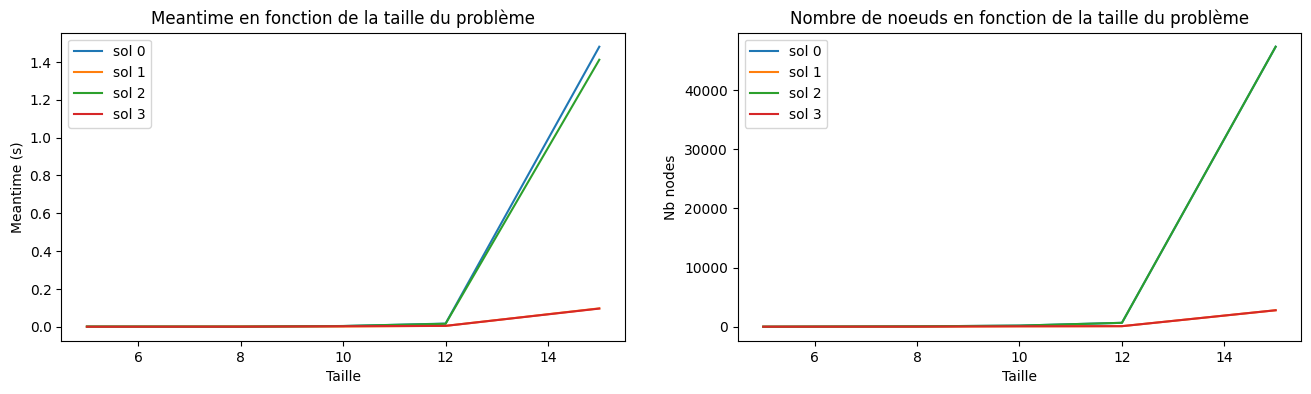

In [8]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
for i in range(len(meanTime)):
    axs[0].plot(liste_n, meanTime[i], label="sol {0}".format(i))
    axs[1].plot(liste_n, nbNodes[i], label="sol {0}".format(i))
    axs[0].set_title("Meantime en fonction de la taille du problème")
    axs[1].set_title("Nombre de noeuds en fonction de la taille du problème")
    axs[0].set_xlabel("Taille")
    axs[1].set_xlabel("Taille")
    axs[0].set_ylabel("Meantime (s)")
    axs[1].set_ylabel("Nb nodes")
    axs[0].legend()
    axs[1].legend()

Le temps d'exécution augmente de manière exponentielle assez rapidement. Notre modèle ne doit probablement pas être bien optimisé. Nous aurions peut être pu diminuer le nombre de contraintes représentant les couples bloquants. Potentiellement en utilisant des méthodes comme le branch and bound vu en PLNE.

De plus nous remarquons que les modèles S1 et S2 ont excatement les mêmes valeurs de temps et de nombre de noeuds parcourus. Cela est dû au fait que nos variables sont très indépendantes du résultat. On n'a pas représenté les préférences des hommes et des femmes par des variables mais seulement avec qui ils sont en couple. Ainsi aucune heuristique de recherche améliore les performances.

# Deuxième Partie

On considère dans cette partie une version d’optimisation de ce problème. 

Étant donné un mariage M , on définit le degré de satisfaction de hi dans M , noté par d(M, hi), comme le rang de son partenaire dans L(hi). 
La satisfaction de H par rapport à M , noté par D(M, H), est la plus grande valeur parmi d(h1, M ), . . . , d(hn, M ). 
On définit de la même façon le degré de satisfaction de fj , noté par d(fi, M ) et celle de F , noté par D(M, F ).

Dans l’exemple de la table 1, on a d(M2, h4) = 2 (car il est couplé avec f1), D(M2, H) = 2 (la pire satisfaction des
agents dans H), d(M2, f2) = 1 (car f2 est couplé à h3) et D(M2, F ) = 4 (la pire satisfaction des agents dans H).

Le problème de mariage stable équilibré est de trouver un mariage stable M tel que |D(M, H) − D(M, F )| est minimale.

### Question 1

Proposez un modèle pour ce problème d’optimisation et testez le avec l’exemple précédant (ou autres exemples).
N’affichez pas les traces d’exécutions internes du solveur.

In [9]:
def add_satisfaction(mdl, Lh, Lf, n, h, f):
    # indices des maries et femmes dans les listes de préférence
    indexesH = mdl.integer_var_list(n, 0, n-1, "i_h")
    indexesF = mdl.integer_var_list(n, 0, n-1, "i_h")
    
    # Maximum de ces indices
    MH, MF = mdl.integer_var_list(2, 0, n-1)
    
    # Associe les indices aux elements
    for i in range(n):
        mdl.add(mdl.element(Lh[i], indexesH[i]) == h[i])
        mdl.add(mdl.element(Lf[i], indexesF[i]) == f[i])
        
    # Maximise MH et MF
    mdl.add(MH == mdl.max(indexesH))
    mdl.add(MF == mdl.max(indexesF))
    # Minimise l'écart entre les 2
    mdl.add(mdl.minimize(abs(MH-MF)))
    return mdl, MF, MH

h, f, mdl = couple_model(Lh, Lf, n)
mdl, MH, MH = add_satisfaction(mdl, Lh, Lf, n, h, f)
sol = mdl.solve()
for i in range(n):
    print("(h_{0}, {1})".format(i, f[sol[h[i]]].name))

 ! ----------------------------------------------------------------------------
 ! Minimization problem - 62 variables, 10896 constraints
 ! Workers              = 1
 ! Presolve             = Off
 ! Initial process time : 0.01s (0.01s extraction + 0.00s propagation)
 !  . Log search space  : 242.2 (before), 242.2 (after)
 !  . Memory usage      : 2.7 MB (before), 2.7 MB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed            Branch decision
                        0         62                 -
 + New bound is 0
                      748         16        F    10 != i_h_3
 + New bound is 1
 *             9      790  0.07s               (gap is 88.89%)
               9     1000         16        F     0  = i_h_4
               9     2000         22        F     1 != i_h_10
 *             3     2335  0.12s               (gap is 66.67%)
               3     3000          9        F 

### Question 2

En utilisant les instances générées dans la première partie, évaluez les deux stratégies S1 et S2 avec une recherche
en profondeur sans restart. Cette fois, on cherche la meilleure solution dans la limite de 200s par exécution.
Présentez vos résultats sous forme de figures qui représentent le temps de résolution ainsi que la qualité des
solutions (i.e., en se basant sur la meilleure valeur) en fonction de la taille de la donnée.

In [ ]:
#On récupère les différentes instances
for i in range(len(instances)) :
    
    Lh = instances[i][0]
    Lf = instances[i][1]
    n = instances[i][2]
    
    #on crée un modèle
    h, f, mdl = couple_model(Lh, Lf, n)
    mdl, MH, MH = add_satisfaction(mdl, Lh, Lf, n, h, f)
    
    # On crée un modèle pour chaque heuristique
    SearchPhase= mdl.add_search_phase(S1)
    lsols = mdl.start_search(trace_log = False, SearchType="DepthFirst", TimeLimit=200)
    
    SearchPhase= mdl.add_search_phase(S2)
    lsols1 = mdl.start_search(trace_log = False, SearchType="DepthFirst", TimeLimit=200)

    # Evaluation des heuristiques
    list_sols = [lsols, lsols1, lsols2, lsols3]
    #Pour chaque instance on a 4 modèles
    for index, heur in enumerate(list_sols):
        size = 0
        #Pour chaque modèle on ajoute le temps et le nb de noeuds de chaque solution
        for sol in heur:
            size += 1
            meanTime[index][int(i/5)] += sol.get_solver_infos()['TotalTime']
            nbNodes[index][int(i/5)] += sol.get_solver_infos()['NumberOfChoicePoints']
            #on fait la moyenne de temps et de noeuds de ces solutions 
            meanTime[index][int(i/5)] = meanTime[index][int(i/5)]/(5+size)
            nbNodes[index][int(i/5)] = nbNodes[index][int(i/5)]/(5+size)
            

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
for i in range(len(meanTime)):
    axs[0].plot(liste_n, meanTime[i], label="sol {0}".format(i))
    axs[1].plot(liste_n, nbNodes[i], label="sol {0}".format(i))
    axs[0].set_title("Meantime en fonction de la taille du problème")
    axs[1].set_title("Nombre de noeuds en fonction de la taille du problème")
    axs[0].set_xlabel("Taille")
    axs[1].set_xlabel("Taille")
    axs[0].set_ylabel("Meantime (s)")
    axs[1].set_ylabel("Nb nodes")
    axs[0].legend()
    axs[1].legend()

### Question 3

Quelles sont vos conclusions ?